In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 1.5MB 15.3MB/s 
     |████████████████████████████████| 890kB 51.2MB/s 
     |████████████████████████████████| 2.9MB 48.0MB/s 


In [ ]:
transformers.__version__

'4.1.1'

In [ ]:
torch == 1.7.0+cu101

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import random
import nltk

import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import DistilBertModel, DistilBertTokenizer
from transformers import DistilBertForSequenceClassification
import torch

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from collections import defaultdict

pd.set_option('display.max_rows', 100)

In [ ]:
pip install pytorch-ignite

     |████████████████████████████████| 184kB 12.1MB/s 


In [ ]:
torch.__version__

'1.7.0+cu101'

In [ ]:
# CPython 3.6.9
# IPython 5.5.0
# numpy 1.18.2
# pandas 1.0.3
# torch 1.4.0
# transformers 2.8.0
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from ignite.metrics import Accuracy, Precision, Recall, Fbeta
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 5
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
path = "/content/drive/My Drive/IMDB Dataset/IMDB Dataset.csv"

In [ ]:

df = pd.read_csv(path)

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


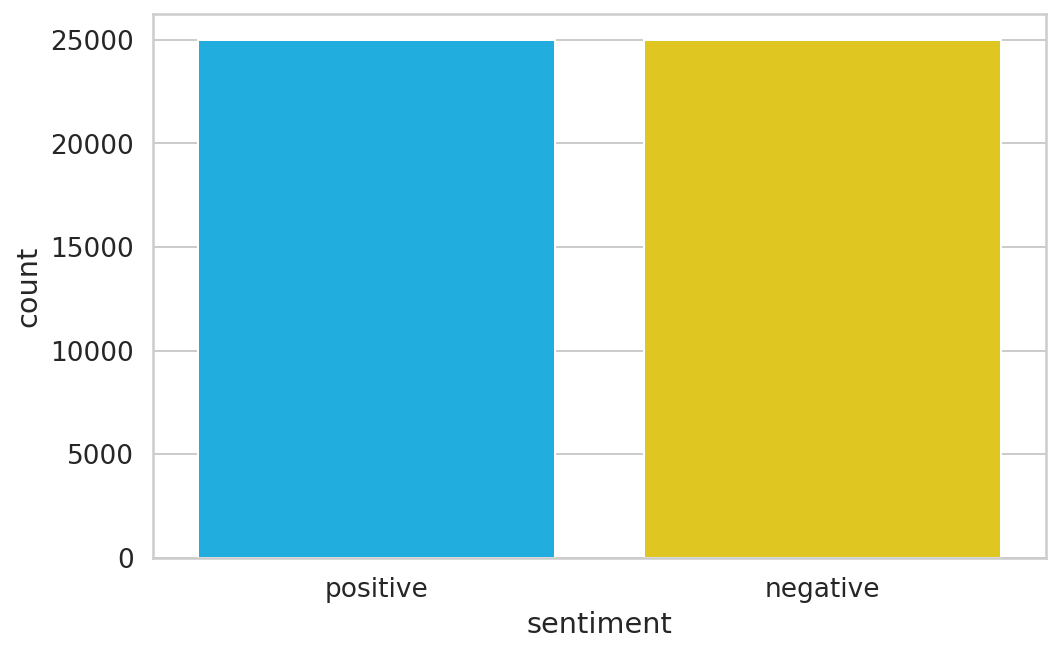

In [ ]:
##### Do we have class imbalance? Lets see

sns.countplot(df.sentiment)
plt.xlabel('sentiment');

In [ ]:
print('Percentage of rows with sentiment 0 in data is {}'.format((len(df[df['sentiment']=='positive'])/len(df)) * 100))
print('Percentage of rows with sentiment 1 in data is {}'.format((len(df[df['sentiment']=='negative'])/len(df)) * 100))


Percentage of rows with sentiment 0 in data is 50.0
Percentage of rows with sentiment 1 in data is 50.0


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Create the function to preprocess every tweet

def process_review(review):
  """Process tweet function.
  Input:
      tweet: a string containing a tweet
  Output:
      tweets_clean: a list of words containing the processed tweet

  """
  # stopwords_english = stopwords.words('english')

  # remove old style retweet text "RT"
  review = re.sub(r'^RT[\s]+', '', review)
  # remove hyperlinks
  review = re.sub(r'https?:\/\/.*[\r\n]*', '', review)
  # remove hashtags
  # only removing the hash # sign from the word
  review = re.sub(r'#', '', review)
  # removing hyphens
  review = re.sub('-', ' ', review)
  # remove linebreaks
  review = re.sub('<br\s?\/>|<br>', "", review)
  # remving numbers
  review = re.sub(r"(\b|\s+\-?|^\-?)(\d+|\d*\.\d+)\b",'',review)
  # # Replace multiple dots with space
  # review = re.sub('\.\.+', '', review) 

  # tokenize tweets
  tokenizer = TweetTokenizer(preserve_case=True, strip_handles=True,
                              reduce_len=True)
  tweet_tokens = tokenizer.tokenize(review)

  # tweet_tokens1 = []
  # for word in tweet_tokens:
  #   word = word.encode('ascii','ignore').decode('utf-8')
  #   tweet_tokens1.append(word)

  # remove numbers
  tweet_tokens = [i for i in tweet_tokens if not i.isdigit()]

  #tweets_clean = ' '.join(tweet_tokens1)

  tweets_clean = []
  for word in tweet_tokens:
    # if (word not in stopwords_english): # remove stopwords
          # tweets_clean.append(word)
      # word = word.replace('</br>','')

    tweets_clean.append(word)

  return ' '.join(tweets_clean)

In [ ]:
# Lets apply above function to every tweet in df

df['review_processed'] = df['review'].apply(process_review)

# df.drop(columns='review',inplace=True)

In [ ]:
# Also lets encode 'sentiment' column. 1 for positive and 0 for negative sentiment

df['sentiment'] = df['sentiment'].map({'positive':1,'negative':0}) 

In [ ]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'

In [ ]:
# Lets load pre-trained Distill BertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
# Lets use below text to understand tokenization process
sample_text = process_review(df['review_processed'][0])

# Lets apply our BertTokenizer on sample text
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence: {sample_text}')
print(f'Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

Sentence: One of the other reviewers has mentioned that after watching just Oz episode you'll be hooked . They are right , as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence , which set in right from the word GO . Trust me , this is not a show for the faint hearted or timid . This show pulls no punches with regards to drugs , sex or violence . Its is hardcore , in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary . It focuses mainly on Emerald City , an experimental section of the prison where all the cells have glass fronts and face inwards , so privacy is not high on the agenda . Em City is home to many .. Aryans , Muslims , gangstas , Latinos , Christians , Italians , Irish and more ... so scuffles , death stares , dodgy dealings and shady agreements are never far away . I would say the main appeal of the show is due to the fact 

For BERT model we need to add Special tokens in to each review. Below are the 
Special tokens

[SEP] - Marker for ending of a sentence - BERT uses 102

[CLS] - We must add this token at start of each sentence, so BERT knows we're doing classification - BERT uses 101

[PAD] - Special token for padding - BERT uses number 0 for this.

[UNK] - BERT understands tokens that were in the training set. Everything else can be encoded using this unknown token



In [ ]:
# All of above work can be done once using encode_plus method

encoding = tokenizer.encode_plus(
  sample_text,
  max_length=32,  # Here for experiment I gave 32 as max_length
  truncation = True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  2028,  1997,  1996,  2060, 15814,  2038,  3855,  2008,  2044,
         3666,  2074, 11472,  2792,  2017,  1005,  2222,  2022, 13322,  1012,
         2027,  2024,  2157,  1010,  2004,  2023,  2003,  3599,  2054,  3047,
         2007,   102])

In [ ]:
# Attention mask also has same length. Zero's in output if any says those corresponds to padding

print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


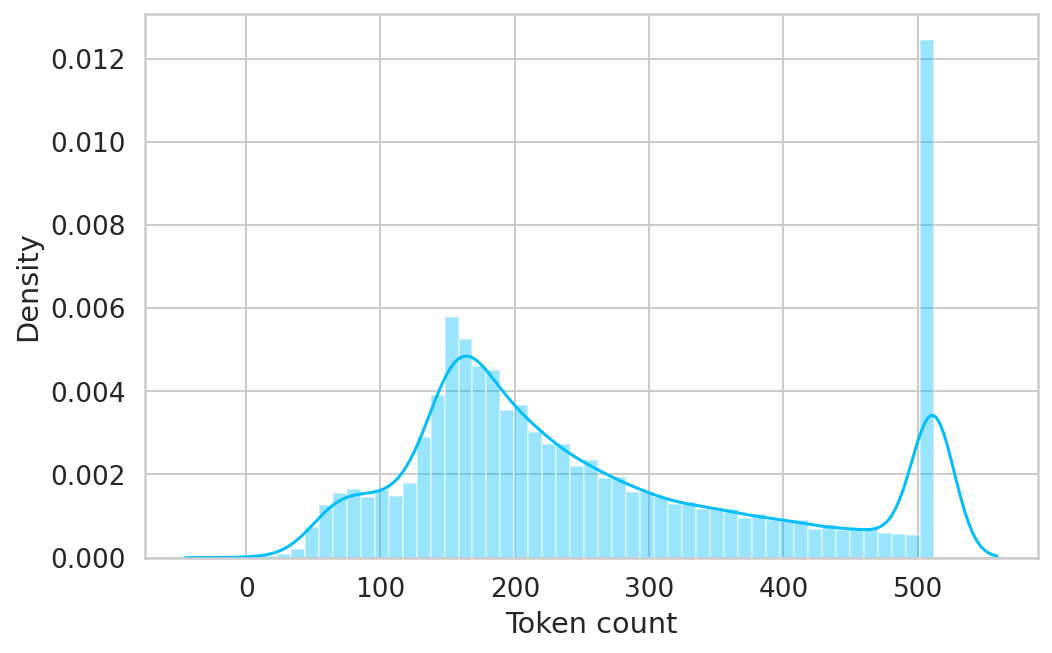

In [ ]:
# Choosing max sequence length since BERT works with fixed length sequences

token_lens = []

for txt in df['review_processed']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

# plot the distribution

sns.distplot(token_lens)
plt.xlabel('Token count');

Seems like most of our reviews have around 100 words but we also see good amount of reviews with around 500 words. I dont want to loose information by just having max length to around 200 and loose information. So lets have max_length of 500 and pad shorter sentences.

In [ ]:
max_len = 512

In [ ]:
t = np.array(token_lens)

t[t >= 500].shape[0]/t.shape[0]

0.1307

#### Now lets create PyTorch dataset from all above building blocks

In [ ]:
class IMDBDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation = True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

#### Lets split data in to train, validation and test data

In [ ]:
# Lets have 70% for training, 15% for validation and 15% for testing

X_train, X_valid, y_train, y_valid = train_test_split(df[['review_processed','review']], df['sentiment'],
                                                    stratify=df['sentiment'], 
                                                    test_size=0.30, random_state = 0)
df_train = pd.concat([pd.DataFrame({'review': X_train['review_processed'].values,'review_old':X_train['review'].values}),pd.DataFrame({'sentiment': y_train.values})], axis = 1)
df_valid = pd.concat([pd.DataFrame({'review': X_valid['review_processed'].values,'review_old':X_valid['review'].values}),pd.DataFrame({'sentiment': y_valid.values})], axis = 1)


X_valid, X_test, y_valid, y_test = train_test_split(df_valid[['review','review_old']], df_valid['sentiment'],
                                                    stratify= df_valid['sentiment'], 
                                                    test_size=0.5, random_state = 0)

df_valid = pd.concat([pd.DataFrame({'review': X_valid['review'].values,'review_old':X_valid['review_old'].values}),pd.DataFrame({'sentiment': y_valid.values})], axis = 1)
df_test = pd.concat([pd.DataFrame({'review': X_test['review'].values,'review_old':X_test['review_old'].values}),pd.DataFrame({'sentiment': y_test.values})], axis = 1)

print(df_train.shape, df_valid.shape, df_test.shape)

(35000, 3) (7500, 3) (7500, 3)


#### Now lets create dataloaders for our train and validation data

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = IMDBDataset(
    reviews=df.review.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )


batch_size = 16      # Bert recommendation

train_data_loader = create_data_loader(df_train, tokenizer, max_len, batch_size)
valid_data_loader = create_data_loader(df_valid, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, batch_size)


In [ ]:
# Lets have a look at an example batch from our traning data

data = next(iter(train_data_loader))

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['input_ids'].shape)


torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])


#### Sentiment classification with Distill BERT and Hugging face

In [ ]:
# Lets build classifier for our reviews now. Below n_classes would be 2 in our case since we are classifying review as either positive or negative.

model = DistilBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels = 2)
model = model.to(device)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [ ]:
# # Lets create an instance and move to GPU. 2 below says we are classifying in to 2 classes

# model = IMDBClassifier(2)
# #model = TweetClassifier(768,2)
# model = model.to(device)

## Training

BERT paper gave some recommendations on hyperparameters for fine tuning

Batch size: 16, 32

Adam learning rate: 5e-5, 3e-5, 2e-5

Number of epochs: 2,3,4

In [ ]:
# Will follow training procedure from BERT paper, will use AdamW optimizer from Hugging Face.

EPOCHS = 5

optimizer = AdamW(model.parameters(), lr = 5e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)


In [ ]:
# Lets write a function to train our model on one epoch

def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):

  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    loss, logits = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      labels = targets
    )

    logits = logits.detach().cpu().numpy()
    label_ids = targets.to('cpu').numpy()

    preds = np.argmax(logits, axis=1).flatten()
    targ = label_ids.flatten()

    correct_predictions += np.sum(preds == targ)

    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions / n_examples, np.mean(losses)

In [ ]:
# Lets write a function to validate our model on one epoch

def eval_model(model, data_loader, device, n_examples):
  
  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      loss, logits = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels = targets
      )


      logits = logits.detach().cpu().numpy()
      label_ids = targets.to('cpu').numpy()

      preds = np.argmax(logits, axis=1).flatten()
      targ = label_ids.flatten()

      correct_predictions += np.sum(preds == targ)
      losses.append(loss.item())

  return correct_predictions / n_examples, np.mean(losses)

#### Lets define our training loop using above two functions

In [ ]:
%%time
# standard block
# used accuracy as metric here
history = defaultdict(list)

best_acc = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, optimizer, device, scheduler, len(df_train))

  print(f'Train loss {train_loss} Accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, valid_data_loader, device, len(df_valid))

  print(f'Val   loss {val_loss} Accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_acc:
    torch.save(model.state_dict(), 'best_model_state_a6.bin')
    best_acc = val_acc

# We are storing state of best model indicated by highest validation accuracy



Epoch 1/5
----------
Train loss 0.2617148899867402 Accuracy 0.8998285714285714
Val   loss 0.20298207050034486 Accuracy 0.9274666666666667

Epoch 2/5
----------
Train loss 0.14249683946047692 Accuracy 0.9554857142857143
Val   loss 0.3469223166976783 Accuracy 0.9148

Epoch 3/5
----------
Train loss 0.07378292897402461 Accuracy 0.9814571428571428
Val   loss 0.3378890427829785 Accuracy 0.9298666666666666

Epoch 4/5
----------
Train loss 0.03493407122269046 Accuracy 0.9921428571428571
Val   loss 0.3964528326490417 Accuracy 0.9349333333333333

Epoch 5/5
----------
Train loss 0.012764203349653431 Accuracy 0.9974285714285714
Val   loss 0.43648903294918695 Accuracy 0.9332

CPU times: user 1h 27min 37s, sys: 1h 7min 13s, total: 2h 34min 51s
Wall time: 2h 36min 14s


In [ ]:
# lets load trained model

path1 = "/content/drive/My Drive/IMDB Dataset/best_model_state_a4.bin"

PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'

model = DistilBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels = 2)
model.load_state_dict(torch.load(path1))

model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [ ]:
# Lets test our model on test data

test_acc, _ = eval_model(model, test_data_loader, device,len(df_test))

test_acc.item()

0.9306666666666666